# ML Assignment – Problem 2a (ONLY)
## K-Means & GMM Clustering on CC GENERAL.csv
This notebook performs preprocessing, clustering, validation, stability, PCA visualization, and cluster interpretation.


In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, adjusted_rand_score
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# Load dataset
file_path = '/content/CC GENERAL.csv'
df = pd.read_csv(file_path)
df.head()

,CUST_ID,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
0,C10001,40.900749,0.818182,95.40,0.00,95.4,0.000000,0.166667,0.000000,0.083333,0.000000,0,2,1000.0,201.802084,139.509787,0.000000,12
1,C10002,3202.467416,0.909091,0.00,0.00,0.0,6442.945483,0.000000,0.000000,0.000000,0.250000,4,0,7000.0,4103.032597,1072.340217,0.222222,12
2,C10003,2495.148862,1.000000,773.17,773.17,0.0,0.000000,1.000000,1.000000,0.000000,0.000000,0,12,7500.0,622.066742,627.284787,0.000000,12
3,C10004,1666.670542,0.636364,1499.00,1499.00,0.0,205.788017,0.083333,0.083333,0.000000,0.083333,1,1,7500.0,0.000000,NaN,0.000000,12
4,C10005,817.714335,1.000000,16.00,16.00,0.0,0.000000,0.083333,0.083333,0.000000,0.000000,0,1,1200.0,678.334763,244.791237,0.000000,12


In [2]:
# Identify ID column and numeric preprocessing
id_col = None
for c in df.columns:
    if 'ID' in c.upper():
        id_col = c
        break

if id_col:
    ids = df[id_col]
    X = df.drop(columns=[id_col])
else:
    ids = pd.Series(range(len(df)), name='index')
    X = df.copy()

for col in X.columns:
    if not np.issubdtype(X[col].dtype, np.number):
        X = X.drop(columns=[col])

X.head()

,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
0,40.900749,0.818182,95.40,0.00,95.4,0.000000,0.166667,0.000000,0.083333,0.000000,0,2,1000.0,201.802084,139.509787,0.000000,12
1,3202.467416,0.909091,0.00,0.00,0.0,6442.945483,0.000000,0.000000,0.000000,0.250000,4,0,7000.0,4103.032597,1072.340217,0.222222,12
2,2495.148862,1.000000,773.17,773.17,0.0,0.000000,1.000000,1.000000,0.000000,0.000000,0,12,7500.0,622.066742,627.284787,0.000000,12
3,1666.670542,0.636364,1499.00,1499.00,0.0,205.788017,0.083333,0.083333,0.000000,0.083333,1,1,7500.0,0.000000,NaN,0.000000,12
4,817.714335,1.000000,16.00,16.00,0.0,0.000000,0.083333,0.083333,0.000000,0.000000,0,1,1200.0,678.334763,244.791237,0.000000,12


In [3]:
# Impute + scale
imputer = SimpleImputer(strategy='median')
X_imp = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X_imp), columns=X.columns)
X_scaled.head()

,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
0,-0.731989,-0.249434,-0.424900,-0.356934,-0.349079,-0.466786,-0.806490,-0.678661,-0.707313,-0.675349,-0.476070,-0.511333,-0.960378,-0.528979,-0.302400,-0.525551,0.36068
1,0.786961,0.134325,-0.469552,-0.356934,-0.454576,2.605605,-1.221758,-0.678661,-0.916995,0.573963,0.110074,-0.591796,0.688678,0.818642,0.097500,0.234227,0.36068
2,0.447135,0.518084,-0.107668,0.108889,-0.454576,-0.466786,1.269843,2.673451,-0.916995,-0.675349,-0.476070,-0.109020,0.826100,-0.383805,-0.093293,-0.525551,0.36068
3,0.049099,-1.016953,0.232058,0.546189,-0.454576,-0.368653,-1.014125,-0.399319,-0.916995,-0.258913,-0.329534,-0.551565,0.826100,-0.598688,-0.228307,-0.525551,0.36068
4,-0.358775,0.518084,-0.462063,-0.347294,-0.454576,-0.466786,-1.014125,-0.399319,-0.916995,-0.675349,-0.476070,-0.551565,-0.905410,-0.364368,-0.257266,-0.525551,0.36068


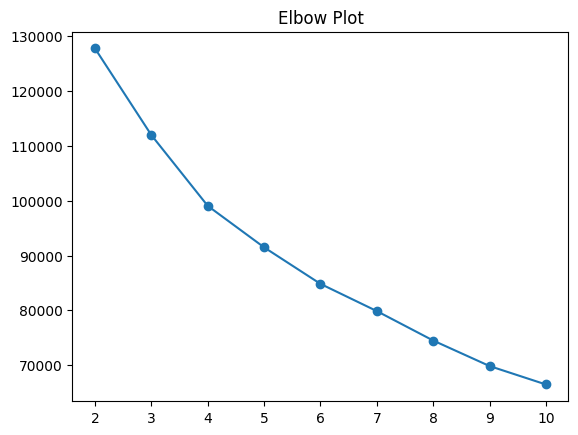

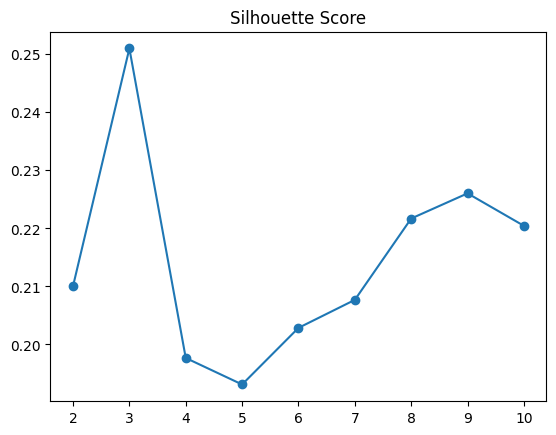

3

In [4]:
# Determine k using elbow + silhouette
ks = range(2, 11)
inertias = []
sils = []

for k in ks:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = km.fit_predict(X_scaled)
    inertias.append(km.inertia_)
    sils.append(silhouette_score(X_scaled, labels))

plt.plot(ks, inertias, marker='o'); plt.title('Elbow Plot'); plt.show()
plt.plot(ks, sils, marker='o'); plt.title('Silhouette Score'); plt.show()

best_k = ks[np.argmax(sils)]
best_k

In [17]:
# Fit KMeans and GMM
k = best_k
kmeans = KMeans(n_clusters=k, random_state=42, n_init=20)
k_labels = kmeans.fit_predict(X_scaled)

gmm = GaussianMixture(n_components=k, random_state=42)
gmm_labels = gmm.fit_predict(X_scaled)

adjusted_rand_score(k_labels, gmm_labels)

0.07114593914002701

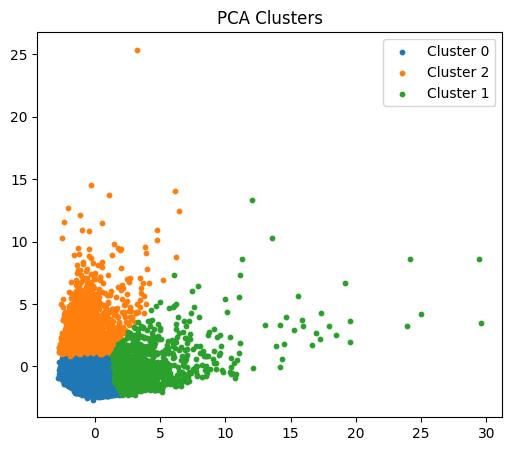

In [7]:
# PCA visualization
pca = PCA(n_components=2)
pc = pca.fit_transform(X_scaled)
pc_df = pd.DataFrame(pc, columns=['PC1','PC2'])
pc_df['cluster'] = k_labels

plt.figure(figsize=(6,5))
for c in pc_df['cluster'].unique():
    subset = pc_df[pc_df['cluster']==c]
    plt.scatter(subset['PC1'], subset['PC2'], s=10, label=f'Cluster {c}')
plt.legend(); plt.title('PCA Clusters'); plt.show()

In [12]:
# Side-by-side comparison of KMeans and GMM cluster assignments

comparison_df = pd.DataFrame({
    "ID": ids,
    "KMeans_Cluster": k_labels,
    "GMM_Cluster": gmm_labels
})

comparison_df.head(20)


,ID,KMeans_Cluster,GMM_Cluster
0,C10001,0,2
1,C10002,2,1
2,C10003,0,2
3,C10004,0,0
4,C10005,0,1
5,C10006,0,0
6,C10007,1,2
7,C10008,0,2
8,C10009,0,2
9,C10010,0,2


In [13]:
print("KMeans cluster counts:")
print(comparison_df["KMeans_Cluster"].value_counts())

print("\nGMM cluster counts:")
print(comparison_df["GMM_Cluster"].value_counts())



KMeans cluster counts:
KMeans_Cluster
0    6119
2    1596
1    1235
Name: count, dtype: int64

GMM cluster counts:
GMM_Cluster
2    3410
1    2934
0    2606
Name: count, dtype: int64


In [14]:
# --- Cluster Stability using 95% subsampling and Adjusted Rand Index ---

from sklearn.metrics import adjusted_rand_score
import numpy as np

n_repeats = 20          # number of subsamples
n = len(X_scaled)       # total samples
sub_n = int(0.95 * n)   # 95% subset size

stability_scores = []

for i in range(n_repeats):
    # Step 1: choose a random 95% subset
    idx = np.random.choice(n, sub_n, replace=False)

    # Step 2: run KMeans on the subset
    km_sub = KMeans(n_clusters=k, random_state=42, n_init=10)
    sub_labels = km_sub.fit_predict(X_scaled.iloc[idx])

    # Step 3: compare subset labels with original labels
    ari = adjusted_rand_score(k_labels[idx], sub_labels)
    stability_scores.append(ari)

print("Stability ARI scores across subsamples:")
print(stability_scores)
print("\nMean Stability ARI:", np.mean(stability_scores))
print("Std Dev:", np.std(stability_scores))


Stability ARI scores across subsamples:
[0.9905708081113717, 0.9859477006897517, 0.9591479910775542, 0.9967759417671584, 0.9800281548296951, 0.9918039254994111, 0.9926697453748787, 0.9841188741325677, 0.9964411632367604, 0.9918912169768554, 0.967119371889741, 0.9822853669362211, 0.9656246494432205, 0.9839545905950339, 0.9766868127125203, 0.9717487489792394, 0.9604088127627234, 0.9740901302654251, 0.9826213765263049, 0.9916062230117614]

Mean Stability ARI: 0.9812770802409096
Std Dev: 0.011384356350287556


In [15]:
from sklearn.metrics import silhouette_score

# Compute silhouette scores for both clustering methods
sil_kmeans = silhouette_score(X_scaled, k_labels)
sil_gmm = silhouette_score(X_scaled, gmm_labels)

print("Silhouette Score (KMeans):", sil_kmeans)
print("Silhouette Score (GMM):", sil_gmm)

# Interpretation helper
if sil_kmeans > sil_gmm:
    print("\nKMeans has the higher silhouette score → better clustering quality.")
elif sil_gmm > sil_kmeans:
    print("\nGMM has the higher silhouette score → better clustering quality.")
else:
    print("\nBoth methods have equal silhouette scores → performance similar.")


Silhouette Score (KMeans): 0.25061926305697263
Silhouette Score (GMM): 0.09779704526202773

KMeans has the higher silhouette score → better clustering quality.


In [18]:
# --- Cluster Centers in Original Scale ---

centers_scaled = kmeans.cluster_centers_
centers_original = scaler.inverse_transform(centers_scaled)

cluster_centers_df = pd.DataFrame(centers_original, columns=X.columns)
cluster_centers_df.index = [f"Cluster {i}" for i in range(k)]
cluster_centers_df


,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
Cluster 0,799.750669,0.835077,505.532394,253.120131,252.733061,330.817885,0.465072,0.132333,0.345145,0.068260,1.209675,8.653865,3271.510637,909.677092,523.213219,0.155750,11.479654
Cluster 1,2228.026120,0.981492,4267.525421,2716.449393,1551.561464,460.625971,0.949134,0.667760,0.744791,0.063367,1.535599,56.478155,7738.228155,4151.340126,1222.192886,0.298390,11.923139
Cluster 2,3984.034534,0.958377,382.864652,248.238834,134.703354,3866.638319,0.231809,0.110908,0.143706,0.447360,12.399373,5.575549,6671.476204,3018.349187,1786.673019,0.033796,11.347335


In [19]:
# --- Basic cluster interpretation (top distinguishing features) ---

global_mean = X.mean()

interpretation = {}

for i in range(k):
    diffs = cluster_centers_df.iloc[i] - global_mean
    top_pos = diffs.sort_values(ascending=False).head(3).index.tolist()
    top_neg = diffs.sort_values().head(3).index.tolist()
    interpretation[f"Cluster {i}"] = {
        "Higher than average features": top_pos,
        "Lower than average features": top_neg
    }

interpretation


{'Cluster 0': {'Higher than average features': ['PRC_FULL_PAYMENT',
   'PURCHASES_INSTALLMENTS_FREQUENCY',
   'PURCHASES_FREQUENCY'],
  'Lower than average features': ['CREDIT_LIMIT', 'PAYMENTS', 'BALANCE']},
 'Cluster 1': {'Higher than average features': ['PURCHASES',
   'CREDIT_LIMIT',
   'PAYMENTS'],
  'Lower than average features': ['CASH_ADVANCE',
   'CASH_ADVANCE_TRX',
   'CASH_ADVANCE_FREQUENCY']},
 'Cluster 2': {'Higher than average features': ['CASH_ADVANCE',
   'BALANCE',
   'CREDIT_LIMIT'],
  'Lower than average features': ['PURCHASES',
   'ONEOFF_PURCHASES',
   'INSTALLMENTS_PURCHASES']}}